In [50]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import highlighting_functions as hf
from importlib import reload

_ = reload(hf)

In [51]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

text = self.pre_process(text)
variables, p_variable = self.find_variables(text)
if variables:
    self.patterns_find["variable"] = p_variable

text = self.syntax_highlight(text)


In [52]:
tokens, tags = hf.tokenize(text)
print(tokens)

['text', ' ', '=', ' ', 'self', '.', 'pre_process', '(', 'text', ')', '\n', 'variables', ',', ' ', 'p_variable', ' ', '=', ' ', 'self', '.', 'find_variables', '(', 'text', ')', '\n', 'if', ' ', 'variables', ':', '\n', ' ', ' ', ' ', ' ', 'self', '.', 'patterns_find', '[', '"variable"', ']', ' ', '=', ' ', 'p_variable', '\n', '\n', 'text', ' ', '=', ' ', 'self', '.', 'syntax_highlight', '(', 'text', ')']


## tagging

In [53]:
print("# tokens", len(tokens))

known_default = {
    "assign": ["=", "<-"],
    "punct": [",", ";", "."],
    "op": r"!%&/+-*:<>^",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": [
        "for",
        "while",
        "foreach",
        "as",
        "in",
        "if",
        "else",
        "elif",
        "and",
        "or",
        "not",
        "return",
    ],
}


# first: tag individual tokens
tags = hf.tag_individuals(tokens, tags, known_default)


# merge and tag again to catch multiple character assignment etc.
tokens, tags = hf.merge_adjacent(tokens, tags, known_default)

# rename brackets
tags, brac_level = hf.bracket_levels(tags)
print(tokens)
print(tags)
# second: context

tags = hf.tag_functions(tokens, tags)
tags = hf.tag_variables(tokens, tags)

# tokens 56
['text', ' ', '=', ' ', 'self', '.', 'pre_process', '(', 'text', ')', '\n', 'variables', ',', ' ', 'p_variable', ' ', '=', ' ', 'self', '.', 'find_variables', '(', 'text', ')', '\n', 'if', ' ', 'variables', ':', '\n    ', 'self', '.', 'patterns_find', '[', '"variable"', ']', ' ', '=', ' ', 'p_variable', '\n\n', 'text', ' ', '=', ' ', 'self', '.', 'syntax_highlight', '(', 'text', ')']
['unk', 'wsp', 'assign', 'wsp', 'unk', 'punct', 'unk', 'brac1', 'unk', 'brac1', 'wsp', 'unk', 'punct', 'wsp', 'unk', 'wsp', 'assign', 'wsp', 'unk', 'punct', 'unk', 'brac1', 'unk', 'brac1', 'wsp', 'keyword', 'wsp', 'unk', 'op', 'wsp', 'unk', 'punct', 'unk', 'brac1', 'str', 'brac1', 'wsp', 'assign', 'wsp', 'unk', 'wsp', 'unk', 'wsp', 'assign', 'wsp', 'unk', 'punct', 'unk', 'brac1', 'unk', 'brac1']


In [54]:
for x in zip(tags, tokens):
    if x[0] == "unk":
        print("\t".join(x))

unk	self
unk	variables
unk	self
unk	variables
unk	self
unk	self


## features

In [55]:
feature_names = (
    "x",
    "x",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

## comments?

- many unknowns
- Starts with token not present in completely tagged lines
- comment symbol
    - not after assign
    - not inside brackets
    - NOT necessatily start of line

In [56]:
lines = []
lines_tags = []

current_line = []
current_line_tags = []
for i, token in enumerate(tokens):
    if "\n" in token:
        lines.append(current_line)
        lines_tags.append(current_line_tags)
        current_line = []
        current_line_tags = []
    else:
        current_line.append(token)
        current_line_tags.append(tags[i])

unks_per_line = [np.array(list([t == "var"] for t in L)).sum() for L in lines]
unks_per_line

[0, 0, 0, 0]

feature matrix (51, 8)
(0, 'x') (1, 'x') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


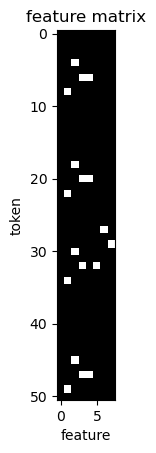

In [57]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 1] = np.array(brac_level)

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features, cmap="gray")
plt.title("feature matrix")
plt.xlabel("feature")
plt.ylabel("token")
plt.show()

(51, 2)


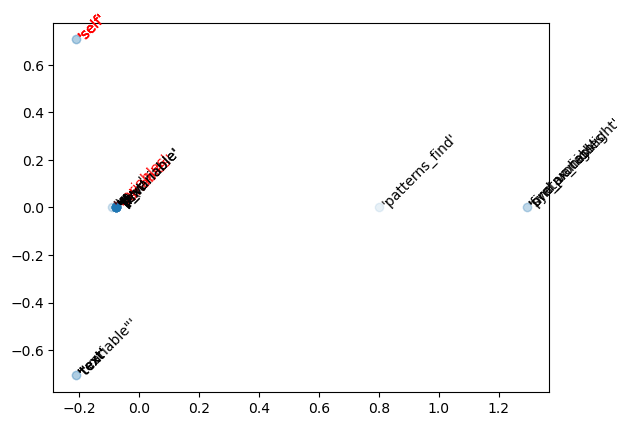

In [58]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()

pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1], alpha=0.1)
for i, t in enumerate(tokens):
    c = "#000"
    if tags[i] == "unk":
        c = "r"
    elif tags[i] == "num":
        c = "g"

    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1], s=repr(t), rotation=45, color=c)

In [59]:
classes = tuple(sorted(set(tags)))
print(classes)

('assign', 'brac1', 'func', 'keyword', 'op', 'punct', 'str', 'unk', 'var', 'wsp')


## cleanup

In [60]:
print("# tokens/tags", len(tokens))

# Merge adjacent of same class
tokens, tags = hf.merge_adjacent(tokens, tags)

print("after merge # tokens/tags", len(tokens))
print("count unknown", sum([t == "unk" for t in tags]))

# tokens/tags 51
after merge # tokens/tags 51
count unknown 6


In [61]:
print(tokens)

['text', ' ', '=', ' ', 'self', '.', 'pre_process', '(', 'text', ')', '\n', 'variables', ',', ' ', 'p_variable', ' ', '=', ' ', 'self', '.', 'find_variables', '(', 'text', ')', '\n', 'if', ' ', 'variables', ':', '\n    ', 'self', '.', 'patterns_find', '[', '"variable"', ']', ' ', '=', ' ', 'p_variable', '\n\n', 'text', ' ', '=', ' ', 'self', '.', 'syntax_highlight', '(', 'text', ')']


In [62]:
EXCLUDE_TAGS = ("unk", "wsp")
html_text = hf.tokens_to_html(tokens, tags, EXCLUDE_TAGS)

print(html_text)

<div class="code-snippet"><span class="var">text</span> <span class="assign">=</span> self<span class="punct">.</span><span class="func">pre_process</span><span class="brac1">(</span><span class="var">text</span><span class="brac1">)</span><br>
variables<span class="punct">,</span> <span class="var">p_variable</span> <span class="assign">=</span> self<span class="punct">.</span><span class="func">find_variables</span><span class="brac1">(</span><span class="var">text</span><span class="brac1">)</span><br>
<span class="keyword">if</span> variables<span class="op">:</span><br>
&nbsp; &nbsp; self<span class="punct">.</span><span class="var">patterns_find</span><span class="brac1">[</span><span class="str">&quot;variable&quot;</span><span class="brac1">]</span> <span class="assign">=</span> <span class="var">p_variable</span><br>
<br>
<span class="var">text</span> <span class="assign">=</span> self<span class="punct">.</span><span class="func">syntax_highlight</span><span class="brac1">(</

## output

In [63]:
css_path = "_style.css"
css_link = f'<link rel="stylesheet" type="text/css" href="{css_path}">'
final_html = f"""
<head>
    {css_link}
</head>
<body>
    {html_text}
</body>
"""

with open("output.html", "w") as f:
    f.write(final_html)


In [64]:
# test method

final_html, classes = hf.highlight_code(text)
with open("output.html", "w") as f:
    f.write(final_html)
